# Lake model

## the lake model
The exploratory modeling workbench includes an example folder. This folder contains a variety of examples that demonstrate the functionality of the workbench. Many of these examples have been drawn from published cases. Here, we use the Lake Problem as an example for demonstrating some of the key functionality of the workbench. 

We demonstrate some of the key capabilities of the exploratory modeling workbench using the Lake problem. The lake problem is a stylized and hypothetical decision problem where the population of a city has to decide on the amount of annual pollution it will put into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication. 

\begin{equation}
    X_{(t+1)}=X_t+a_t+\frac{(X_t^q)}{(1+X_t^q )}- bX_t+\epsilon_t
\end{equation}

where $X_t$ is the pollution at time $t$, $a_t$ is the rate of anthropogenic pollution at time $t$, $b$ is the lake’s natural recycling rate, $\epsilon_t$ is the rate of natural pollution at time $t$. The rate of anthropogenic pollution $a_t$ is the decision variable and is somewhere between 0, and 0.1. So $a_t \in [0,0.1]$. The natural pollution $\epsilon_t$ is modeled, following Singh et al. (2015), as a log normal distribution with mean $\mu$ and standard deviation $\sigma$. 
There are four outcomes of interest. The first is the average concentration of phosphor in the lake. 

\begin{equation}
    f_{phosphorus}=  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t\in{T}} X_t 
\end{equation}

where $\left\vert{T}\right\vert$ is the cardinality of the set of points in time. 
The second objective is the economic benefit derived from polluting the lake. Following Singh et al. (2015), this is defined as the discounted benefit of pollution mines the costs of having a polluted lake

\begin{equation}
    f_{economic} = \sum\limits_{t \in {T}}\alpha a_t \delta^t 
\end{equation}

where $\alpha$ is the utility derived from polluting and $\delta$ is the discount rate. By default, $\alpha$ is 0.04.
The third objective is related to the year over year change in the anthropogenic pollution rate. 

\begin{equation}
    f_{inertia} =\frac{1}{\left\vert{T}\right\vert-1} \sum\limits_{t=1}^{\left\vert{T}\right\vert} I(|a_{t}-a_{t-1} |>\tau)   
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $\tau$ is the threshold that is deemed undesirable, and is for illustrative purposes et to 0.2. Effectively, f_{inertia} is the fraction of years where the absolute value of the change in anthropogenic pollution is larger then $\tau$.
The fourth objective is the fraction of years where the pollution in the lake is below the critical threshold.

\begin{equation}
    f_{reliability} =  \frac{1}{\left\vert{T}\right\vert} \sum\limits_{t \in T}I(X_{t}<X_{crit} ) 
\end{equation}

where $I$ is an indicator function that is 0 if the statement is false, and 1 if the statement is true, $X_{crit}$ is the critical threshold of pollution and is a function of both $b$ and $q$.

The lake problem is characterized by both stochastic uncertainty and deep uncertainty. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 


## Assignment
1. find online a Python implementation of the lake problem in python. Adapt this code and connect it to the workbench

for the uncertainties, use the following table

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |

For now, assume that for each year a release decision is made. The release is between 0 and 0.1.

2. Explore the behavior of the system in the absence of any release using 1000 scenarios, and the default sampling approach.
    * visualize the outcomes of interest, are there any apparent trade-offs?
    * can you visually identify the uncertainties that drive system behavior?
3. Explore the behavior of the system over 1000 scenarios for 4 randomly sampled candidate strategies.
    * visualize the outcomes of interest
    * what can you say about how the release decision influences the system?
4. If you have not used parallelization in the foregoing, try to adapt your code to use parallelization. The workbench comes with two evaluators for parallelization. The `MultiProcessingingEvaluator` and the `IpyparallelEvaluator`. When can you use each?
    

# Model answer
To start, we can find two implementations of the model in Python. One by me, and one by Jon Herman. Let's use the Jon Herman version, for explanatory purposes. It can be found here: https://gist.github.com/jdherman/d519b3ef81840fc27d96

The full code is given below. Let's adapt this code for use with the workbench. 

```python

from __future__ import division
import numpy as np
from scipy.optimize import brentq as root
from borg import *

nvars = 100 # decision variables: pollution for each timestep
nobjs = 4
nconstr = 1
nsamples = 100 # 100 scenarios of natural inflows
b = 0.42 # decay rate for P in lake (0.42 = irreversible)
q = 2.0 # recycling exponent
alpha = 0.4 # utility from pollution
delta = 0.98 # (1-r) discount rate
Pcrit = root(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)

def lake(*decisions):
  objs = [0.0]*nobjs
  constr = [0.0]
  X = np.zeros((nvars,))
  average_daily_P = np.zeros((nvars,))
  decisions = np.array(decisions)

  for s in xrange(nsamples):
    X[0] = 0
    natural_inflows = np.random.lognormal(-3.52, 0.105, size=nvars)
    
    for t in xrange(1,nvars):
      X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]
      average_daily_P[t] += X[t]/nsamples

    objs[3] -= np.sum(X < Pcrit)/(nsamples*nvars) # Maximize timesteps satisfying X < Pcrit
  
  objs[0] = np.max(average_daily_P) # Minimize the maximum daily P in lake
  objs[1] = -1*np.sum(alpha*decisions*np.power(delta,np.arange(nvars))) # Maximize the average sum of discounted benefits
  objs[2] = -1*np.sum(np.diff(decisions) > -0.02)/(nvars-1) # Maximize timesteps meeting inertia threshold

  constr[0] = Constraint.greaterThan(-1*objs[3], 0.95)
  return (objs, constr)

borg = Borg(nvars, nobjs, nconstr, lake)
borg.setBounds(*[[0.0, 0.1]]*nvars)
borg.setEpsilons(*[0.01]*nobjs)

result = borg.solve({"maxEvaluations":10000})

for solution in result:
  print solution.getObjectives() + solution.getConstraints()
  
```

As you can see, in this code, a function called lake is defined. This function is optimized using the Borg algorithm. For now, we only need the function part. So we can remove anything related to borg. If we do this, we get the following:

```python

from __future__ import division
import numpy as np
from scipy.optimize import brentq as root
# from borg import *

nvars = 100 # decision variables: pollution for each timestep
nobjs = 4
# nconstr = 1
nsamples = 100 # 100 scenarios of natural inflows
b = 0.42 # decay rate for P in lake (0.42 = irreversible)
q = 2.0 # recycling exponent
alpha = 0.4 # utility from pollution
delta = 0.98 # (1-r) discount rate
Pcrit = root(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)

def lake(*decisions):
  objs = [0.0]*nobjs
#   constr = [0.0]
  X = np.zeros((nvars,))
  average_daily_P = np.zeros((nvars,))
  decisions = np.array(decisions)

  for s in xrange(nsamples):
    X[0] = 0
    natural_inflows = np.random.lognormal(-3.52, 0.105, size=nvars)
    
    for t in xrange(1,nvars):
      X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]
      average_daily_P[t] += X[t]/nsamples

    objs[3] -= np.sum(X < Pcrit)/(nsamples*nvars) # Maximize timesteps satisfying X < Pcrit
  
  objs[0] = np.max(average_daily_P) # Minimize the maximum daily P in lake
  objs[1] = -1*np.sum(alpha*decisions*np.power(delta,np.arange(nvars))) # Maximize the average sum of discounted benefits
  objs[2] = -1*np.sum(np.diff(decisions) > -0.02)/(nvars-1) # Maximize timesteps meeting inertia threshold

#   constr[0] = Constraint.greaterThan(-1*objs[3], 0.95)
#   return (objs, constr)
    return objs

# borg = Borg(nvars, nobjs, nconstr, lake)
# borg.setBounds(*[[0.0, 0.1]]*nvars)
# borg.setEpsilons(*[0.01]*nobjs)

# result = borg.solve({"maxEvaluations":10000})

# for solution in result:
#   print solution.getObjectives() + solution.getConstraints()
  
```

For clarity, I have only commented out the lines we don't need. In the next step, I will remove these lines completely. For our purpose, we would like to be able to explore the behavior of the lake model over both uncertainties as well as levers. To do this, we should move the uncertain parameters into the call signature of the lake function. 

The workbench assumes by default that the name of an uncertainty is identical to keyword of a keyword argument. So, if we have an uncertainty named b, the function should have b as a keyword argument. So, let's update the code to make it compatible with this

```python

from __future__ import division
import numpy as np
from scipy.optimize import brentq as root

def lake(b=0.42,          # decay rate for P in lake (0.42 = irreversible)
         q=2.0,           # recycling exponent
         delta=0.98,      # standard deviation of natural inflows
         alpha=0.4,       # utility from pollution
         nsamples=100, 
         **kwargs): #TODO:: fixme
    nvars = 100 # decision variables: pollution for each timestep
    nobjs = 4

    objs = [0.0]*nobjs
    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    decisions = np.array(decisions) #TODO: fixme

    Pcrit = root(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)

    for s in xrange(nsamples):
        X[0] = 0
        natural_inflows = np.random.lognormal(-3.52, 0.105, size=nvars)

        for t in xrange(1,nvars):
            X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]
            average_daily_P[t] += X[t]/nsamples

        objs[3] -= np.sum(X < Pcrit)/(nsamples*nvars) 

    objs[0] = np.max(average_daily_P) 
    objs[1] = -1*np.sum(alpha*decisions*np.power(delta,np.arange(nvars))) 
    objs[2] = -1*np.sum(np.diff(decisions) > -0.02)/(nvars-1) 

    return objs
 
```
As you can see, I have put a todo in the code. With these changes, we no longer have the release decision in a proper format. The way it was done in the original code was as a list with a value for each timestep. The workbench won't generate something like that. Decisions, like uncertainties, have to be keyword arguments. A simple solution is to generate the decision for each timestep using levers, where the name of the lever correspons to the year to which the decision applies. So let's fix the TODO's. 

```python

from __future__ import division
import numpy as np
from scipy.optimize import brentq as root

def lake(b=0.42,          # decay rate for P in lake (0.42 = irreversible)
         q=2.0,           # recycling exponent
         delta=0.98,      # standard deviation of natural inflows
         alpha=0.4,       # utility from pollution
         nsamples=100, 
         **kwargs): 
    nvars = 100 # decision variables: pollution for each timestep
    nobjs = 4

    objs = [0.0]*nobjs
    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    decisions = [kwargs[str(i)] for i in range(nvars)]
    decisions = np.array(decisions)

    Pcrit = root(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)

    for s in xrange(nsamples):
        X[0] = 0
        natural_inflows = np.random.lognormal(-3.52, 0.105, size=nvars)

        for t in xrange(1,nvars):
            X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]
            average_daily_P[t] += X[t]/nsamples

        objs[3] -= np.sum(X < Pcrit)/(nsamples*nvars) 

    objs[0] = np.max(average_daily_P) # the maximum daily P in lake
    objs[1] = -1*np.sum(alpha*decisions*np.power(delta,np.arange(nvars))) 
    objs[2] = -1*np.sum(np.diff(decisions) > -0.02)/(nvars-1) 
    
    return objs
 
```

If we now compare the function signature with the table of uncertainties, we are still missing two uncertainties: $\mu$ and $\sigma$. These control the parameterization of the lognormal natural inflow. If you look at the calculation of the natural inflows in the foregoing, you see two hard coded parameters. These values are derived from $\mu$ and $\sigma$. If you read the documentation of numpy.random.lognormal (https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.lognormal.html), you see that the function expect the $\mu$ and $\sigma$ of the underlying normal distribution. The ranges we have, however, are for the lognormal, so we need to do a conversion: https://nl.mathworks.com/help/stats/lognstat.html?requestedDomain=www.mathworks.com . Note that the math there uses the variance rather than the standard deviation.

```python

from __future__ import division
import numpy as np
from scipy.optimize import brentq as root

def lake(b=0.42,          # decay rate for P in lake (0.42 = irreversible)
         q=2.0,           # recycling exponent
         mean=0.02,       # mean of natural inflows
         stdev=0.001,     # future utility discount rate
         delta=0.98,      # standard deviation of natural inflows
         alpha=0.4,       # utility from pollution
         nsamples=100, 
         **kwargs): 
    nvars = 100 # decision variables: pollution for each timestep
    nobjs = 4

    objs = [0.0]*nobjs
    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    decisions = [kwargs[str(i)] for i in range(nvars)]
    decisions = np.array(decisions)

    Pcrit = root(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)

    for s in xrange(nsamples):
        X[0] = 0

        natural_inflows = np.random.lognormal(
                math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
                math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
                size = nvars)

        for t in xrange(1,nvars):
            X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]
            average_daily_P[t] += X[t]/nsamples

        objs[3] -= np.sum(X < Pcrit)/(nsamples*nvars) 

    objs[0] = np.max(average_daily_P) 
    objs[1] = -1*np.sum(alpha*decisions*np.power(delta,np.arange(nvars))) 
    objs[2] = -1*np.sum(np.diff(decisions) > -0.02)/(nvars-1) 

    return objs
 
```

We are almost there. A few remaining things:
* xrange is defined only in Python2, so we replace that with range which works under both Python2 and Python3
* why put the objectives in a list if we instead can simply return a tuple. The advantage of the tuple is that we can also be more explicit about what each outcome of interest is. Here we have to be a bit careful. The original code was used for an optimization problem where the algorithm assumes minimization. If one of the objectives has to be maximized, you multiply it by -1. 

If we make these changes we get the following:


```python

from __future__ import division
import numpy as np
from scipy.optimize import brentq as root

def lake(b=0.42,          # decay rate for P in lake (0.42 = irreversible)
         q=2.0,           # recycling exponent
         mean=0.02,       # mean of natural inflows
         stdev=0.001,     # future utility discount rate
         delta=0.98,      # standard deviation of natural inflows
         alpha=0.4,       # utility from pollution
         nsamples=100,    # number of replications
         **kwargs): 
    nvars = 100 # decision variables: pollution for each timestep

    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    decisions = [kwargs[str(i)] for i in range(nvars)]
    decisions = np.array(decisions)
    reliability = 0

    Pcrit = root(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)

    for s in range(nsamples):
        X[0] = 0

        natural_inflows = np.random.lognormal(
                math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
                math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
                size = nvars)

        for t in range(1,nvars):
            X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]
            average_daily_P[t] += X[t]/nsamples

        reliability += np.sum(X < Pcrit)/(nsamples*nvars) 

    max_P = np.max(average_daily_P) 
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(nvars))) 
    inertia = np.sum(np.diff(decisions) > -0.02)/(nvars-1) 

    return max_P, utility, inertia, reliability
 
```

Now the function is ready to be used in combination with the workbench. Still, there is one more step we could take. The workbench offers support for running replications. We could remove the outer loop (`for s in range(nsamples)`), and make the workbench responsible for this. In this case, the function becomes:

```python

from __future__ import division
import numpy as np
from scipy.optimize import brentq as root

def lake(b=0.42,          # decay rate for P in lake (0.42 = irreversible)
         q=2.0,           # recycling exponent
         mean=0.02,       # mean of natural inflows
         stdev=0.001,     # future utility discount rate
         delta=0.98,      # standard deviation of natural inflows
         alpha=0.4,       # utility from pollution
         **kwargs): 
    nvars = 100 # decision variables: pollution for each timestep

    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    decisions = [kwargs[str(i)] for i in range(nvars)]
    decisions = np.array(decisions)

    Pcrit = root(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)

    X[0] = 0

    natural_inflows = np.random.lognormal(
            math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
            math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
            size = nvars)

    for t in range(1,nvars):
        X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]
        average_daily_P[t] += X[t]

    reliability = np.sum(X < Pcrit)/nvars
    max_P = np.max(average_daily_P)
    utility = -1*np.sum(alpha*decisions*np.power(delta,np.arange(nvars))) 
    inertia = -1*np.sum(np.diff(decisions) > -0.02)/(nvars-1) 
    
    return max_P, utility, inertia, reliability
 
```

Near the end of this notebook, I will briefly show how the workbench can be used for replication, but for now we start without this additional complication.


In [1]:
from scipy.optimize import brentq
import math

def lake_problem(
         b = 0.42,          # decay rate for P in lake (0.42 = irreversible)
         q = 2.0,           # recycling exponent
         mean = 0.02,       # mean of natural inflows
         stdev = 0.001,     # future utility discount rate
         delta = 0.98,      # standard deviation of natural inflows
         alpha = 0.4,       # utility from pollution
         nsamples = 100,    # Monte Carlo sampling of natural inflows
         **kwargs):   
    decisions = [kwargs[str(i)] for i in range(100)]
    
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    nvars = len(decisions)
    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    decisions = np.array(decisions)
    reliability = 0.0

    for _ in range(nsamples):
        X[0] = 0.0
        
        natural_inflows = np.random.lognormal(
                math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
                math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
                size = nvars)
        
        for t in range(1,nvars):
            X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] +\
                    natural_inflows[t-1]
            average_daily_P[t] += X[t]/float(nsamples)
    
        reliability += np.sum(X < Pcrit)/float(nsamples*nvars)
      
    max_P = np.max(average_daily_P)
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(nvars)))
    inertia = np.sum(np.diff(decisions) > -0.02)/float(nvars-1)

    return max_P, utility, inertia, reliability

In [2]:
from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

# override some of the defaults of the model
lake_model.constants = [Constant('alpha', 0.41),
                        Constant('nsamples', 150)]



## explore behavior in absence of policy

To keep things simple, we start with exploring the behavior of the lake system without any policy. The workbench offers support for sampling / searching for policies, but we can also pre-specify them ourselves which is what we can do here

Another simplification is that we are going to run the code sequentially, using the perform_experiments function. 


In [3]:
from ema_workbench import Policy, perform_experiments
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

policy = Policy("no release", **{l.name:0 for l in lake_model.levers})
n_scenarios = 1000
results = perform_experiments(lake_model, n_scenarios, policy)


[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


We have now performed the experiments and we need to make sense of the results. If you want to understand the structure of the return of perform_experiments, you can do a few things:
* pull up the documentation of the function. Simply type perform_experiments? in a code block and hit enter. The documentation will automatically show up
* do some interactive exploration using e.g. type, len, and other functions. It is not to hard to figure out in this way what you are dealing with
* save the results, and unzip the tarbal. This is the hard way which I don't recommend but it can be done. the save_results function in the workbench, and its complement load_results are quite convenient to save your work between sessions. They also store the results in a human readable format so you can do analyses in other tools easily. 

results is a tuple of length 2. The first entry is a numpy structured array with the experiments. The second entry is a dict with the name of the outcome as key, and a numpy array as value. Experiments and outcomes are aligned by index. 

Let's make a simple pair wise scatter plot of all the outcomes, for this we can use seaborn.


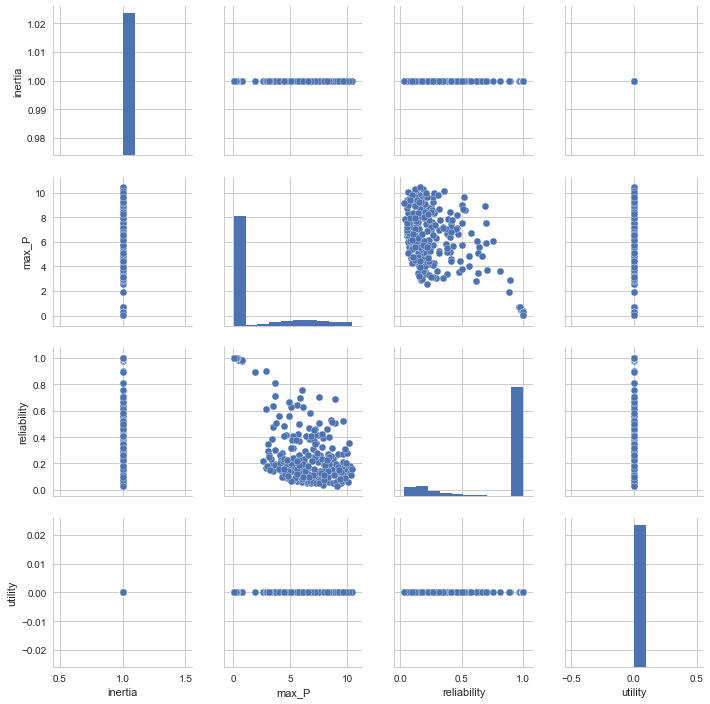

In [4]:
experiments, outcomes = results

sns.pairplot(pd.DataFrame.from_dict(outcomes))
plt.show()

The main thing that is of note here is that only between reliability and max_p is there a tradeoff. Utility and inertia are zero because we have no policy.

## some random policies

let's make the results a bit more interesting by sampling simultaneously over both levers and uncertainties. For bonus points we override the default use of latin hypercube sampling with monte carlo sampling for the levers only. Again, this can be quickly gathered from the documentation of perform_experiments.

In [5]:

n_scenarios = 100
n_policies = 4

results = perform_experiments(lake_model, n_scenarios, n_policies, 
                              levers_sampling="mc")



[MainProcess/INFO] performing 100 scenarios * 4 policies * 1 model(s) = 400 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 280 cases completed
[MainProcess/INFO] 320 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] experiments finished


We can now make a pairwise scatter plot using seaborn. A few things to bear in mind however. First, we better copy our data before operating on it. We can either copy the data using the copy library, or the numpy copy in case of an array.

Second, the names of the policy are unreadable. So let's recode the policy lables and use numbers instead. 

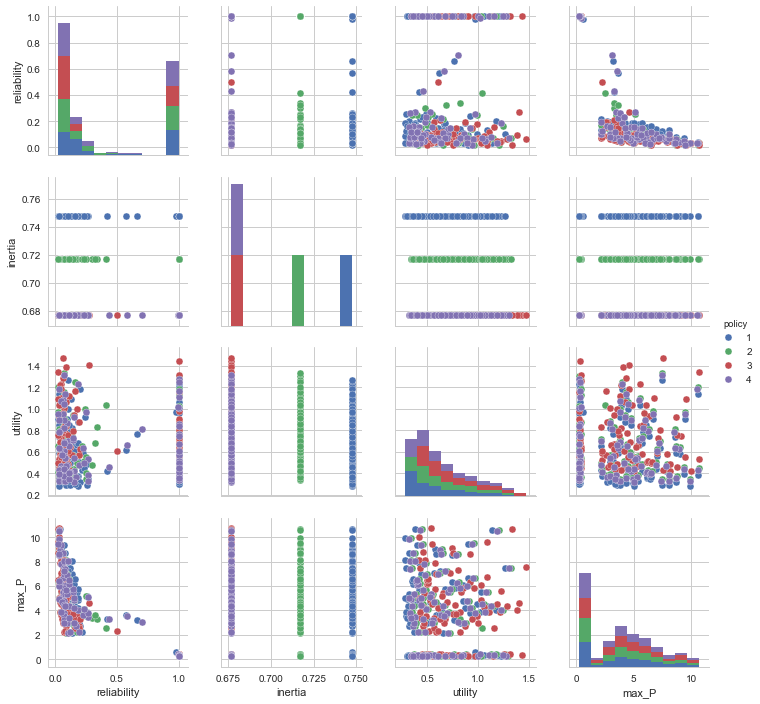

In [6]:
import copy

experiments, outcomes = results
policy = np.copy(experiments["policy"])

for i, entry in enumerate(set(policy)):
    logical = policy==entry
    policy[logical] = str(i+1)

data = copy.copy(outcomes)
data["policy"] = policy
data = pd.DataFrame.from_dict(data)
sns.pairplot(data, hue="policy", vars=outcomes.keys())
plt.show()

## more advanced solution

In the above, we change the names of the policies after the fact. It is possible to control naming when the policies are generated as shown below.

note, this code requires the latest version of the workbench because of a small error that I have fixed (so pip install ema_workbench -U)


In [7]:
from ema_workbench.em_framework import sample_levers

class Character(object):
    '''returns a character in the order of the alphabet
    
    ..note:: will fail if we get past 26 calls
    
    '''

    def __init__(self):
        self.counter = -1
        
    def __call__(self, kwargs):
        self.counter += 1
        return chr(ord('a') + self.counter)
    
policies = sample_levers(lake_model,n_samples=4, name=Character())
results = perform_experiments(lake_model, scenarios=10, policies=policies)


[MainProcess/INFO] performing 10 scenarios * 4 policies * 1 model(s) = 40 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 12 cases completed
[MainProcess/INFO] 16 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] 28 cases completed
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 36 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] experiments finished


In [8]:
experiments, outcomes = results
set(experiments['policy'])

{'a', 'b', 'c', 'd'}

# parallelization  

To save runtime, it is convenient to exploit the fact that most modern day computers can support multiple processes simultaneously. There are two ways we can do this with the workbench: using the multiprocessing library, or the ipyparallel library. The workbench comes with convenient evaluators that abstract away most of the intricacies of dealing with these libraries. Still, parallelization is something you have to be careful with. As a general rule: make it work sequentially before running in parallel; and run in parallel on a small number of experiments with logging set to debug before scaling up. 

## MultiprocessingEvaluator

The `MultiprocessingEvaluator` can be used for parallelization on a local machine, defaulting to the total number of cores (i.e. the number of processes your computer can run simultaneously). When you are running things in parallel, you are effectively starting multiple python processes. The way this is done differs between Mac and Linux, and Windows. On Mac and Linux, a copy of the existing process is made. On Windows, a new process is started. Given that a Python process has state, the new Windows process needs to know about the lake_model function. However, it cannot read this from a notebook. Instead, you have to define it in a .py file. On mac and linux, however the original process is copied and thus the lake_model function definition is also copied. 

The code below will work also on a windows machine. Note how in the first line I am importing the lake_problem function from a python module (i.e. a .py file). 

In [9]:
from lakemodel_function import lake_problem

from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

# override some of the defaults of the model
lake_model.constants = [Constant('alpha', 0.41),
                        Constant('nsamples', 150)]



In [10]:
from ema_workbench import ema_logging
from ema_workbench import MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(lake_model) as evaluator:
    evaluator.perform_experiments(scenarios=2, policies=2)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2 scenarios * 2 policies * 1 model(s) = 4 experiments
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


## IpyparallelEvaluator
The `IpyparallelEvaluator` uses ipyparallel for parallelization. This library is ideally suited to use in combination with the notebook. Ipyparallel can be used on a single machine, but also across multiple machines. The main drawback is that you need to start the ipyparalel cluster outside of a notebook in a terminal. Next, you need to know the profile you are using for the cluster so that you can connect the evaluator to this cluster. Then you need to define the lake_problem function using ipyparallel magics. 

using ipyparallel is a more sophisticated but very powerful way on doing parallelization. Below I give an example of how it can be used. Note that I have first started in a seperate terminal an ipyparallel cluster: `ipcluster start --n=2` . Here the --n=2 argument is optional. It means that I am starting a cluster with 2 processes. If you are interested in using ipyparallel, please take the time to read through the documentation of ipyparallel.

next, we can connect this notebook to the started cluster by instantiating a client

In [12]:
import ipyparallel

client = ipyparallel.Client()
client.ids


[0, 1]

Similar to the multiprocessing, we must make sure that the lake_problem function is defined in all the running processes. Ipyparallel makes this easy by using cell magics (the % and %% signs). The code below is executed on each ipyparallel python process (specified by %%px), as well as in the python process associated with this running notebook (specified by the --local optional argument)

In [13]:
%%px --local
# this entire block is executed 3 times

import numpy as np
from scipy.optimize import brentq
import math

def lake_problem(
         b = 0.42,          # decay rate for P in lake (0.42 = irreversible)
         q = 2.0,           # recycling exponent
         mean = 0.02,       # mean of natural inflows
         stdev = 0.001,     # future utility discount rate
         delta = 0.98,      # standard deviation of natural inflows
         alpha = 0.4,       # utility from pollution
         nsamples = 100,    # Monte Carlo sampling of natural inflows
         **kwargs):   
    decisions = [kwargs[str(i)] for i in range(100)]
    
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    nvars = len(decisions)
    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    decisions = np.array(decisions)
    reliability = 0.0

    for _ in range(nsamples):
        X[0] = 0.0
        
        natural_inflows = np.random.lognormal(
                math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
                math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
                size = nvars)
        
        for t in range(1,nvars):
            X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] +\
                    natural_inflows[t-1]
            average_daily_P[t] += X[t]/float(nsamples)
    
        reliability += np.sum(X < Pcrit)/float(nsamples*nvars)
      
    max_P = np.max(average_daily_P)
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(nvars)))
    inertia = np.sum(np.diff(decisions) > -0.02)/float(nvars-1)

    return max_P, utility, inertia, reliability

In [14]:
from ema_workbench import (Model, RealParameter, ScalarOutcome, Constant)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_problem)
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

# override some of the defaults of the model
lake_model.constants = [Constant('alpha', 0.41),
                        Constant('nsamples', 150)]




In [15]:
from ema_workbench import ema_logging
from ema_workbench.em_framework import IpyparallelEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

with IpyparallelEvaluator(lake_model, client=client) as evaluator:
    evaluator.perform_experiments(scenarios=2, policies=2)

[MainProcess/INFO] performing experiments using ipyparallel
[MainProcess/INFO] performing 2 scenarios * 2 policies * 1 model(s) = 4 experiments
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] experiments finished


# Replication with the workbench

In the code up till here, we ran a number of replications within the lake problem function. It is possible to move the responsibility for this to the workbench. To do this, we remove the loop from the function, and remove the division by nsamples. 


In [16]:
from scipy.optimize import brentq as root
import math

def lake(b=0.42,          # decay rate for P in lake (0.42 = irreversible)
         q=2.0,           # recycling exponent
         mean=0.02,       # mean of natural inflows
         stdev=0.001,     # future utility discount rate
         delta=0.98,      # standard deviation of natural inflows
         alpha=0.4,       # utility from pollution
         **kwargs): 
    nvars = 100 # decision variables: pollution for each timestep

    X = np.zeros((nvars,))
    average_daily_P = np.zeros((nvars,))
    decisions = [kwargs[str(i)] for i in range(nvars)]
    decisions = np.array(decisions)
    
    Pcrit = root(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)

    X[0] = 0

    natural_inflows = np.random.lognormal(
            math.log(mean**2 / math.sqrt(stdev**2 + mean**2)),
            math.sqrt(math.log(1.0 + stdev**2 / mean**2)),
            size = nvars)

    for t in range(1,nvars):
        X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]
        average_daily_P[t] += X[t]

    reliability = np.sum(X < Pcrit)/nvars
    max_P = np.max(average_daily_P)
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(nvars))) 
    inertia = np.sum(np.diff(decisions) > -0.02)/(nvars-1) 
    
    return max_P, utility, inertia, reliability

Next, we need a Model class that handles the replications. By default, `Model` does not do this. We can easily create such a class by combining the `Replicator` class and the `BaseModel` class. 

Note that most model interface classes, with the exception of the NetLogoModel, by default do not implement replications. 

In [17]:
from ema_workbench.em_framework.model import Replicator, BaseModel

class ReplicatorModel(Replicator, BaseModel):
    pass

We can now setup the model as before, but with using the `ReplicatorModel` and the newly defined `lake` function.

In [18]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant)
from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
lake_model = ReplicatorModel('lakeproblem', function=lake)
lake_model.replications = 10
lake_model.time_horizon = 100 # used to specify the number of timesteps

#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in 
                     range(lake_model.time_horizon)] # we use time_horizon here

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P'),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

# override some of the defaults of the model
lake_model.constants = [Constant('alpha', 0.41)]



In [19]:
from ema_workbench import Policy, perform_experiments

n_scenarios = 100
policy = Policy("no release", **{l.name:0.0 for l in lake_model.levers})
experiments, outcomes = perform_experiments(lake_model, scenarios=n_scenarios, 
                                            policies=policy)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [20]:
for key, value in outcomes.items():
    print("{key} has shape {shape}".format(key=key, shape=value.shape))

reliability has shape (100, 10)
inertia has shape (100, 10)
utility has shape (100, 10)
max_P has shape (100, 10)


The results have a shape of 100 by 10. 100 is the number of experiments, 10 is the number of replications. That is, by default, each of the individual replications is stored. If we go back to the original code of the lake problem, you will see that all the objectives, where relevant, are divided by the number of samples. The number of samples is the number of replications. So, each objective is the average over the number of replications. 

To replicate this behavior with the workbench, we need to do some postprocessing of the results. We can do this after we have generated the results. But the workbench also has the option of doing this processing while the results are coming in. We can do this by passing a function when we instantiate an outcome. This function will be called with the results of a single experiment, for that specific outcome. So, in the code below, `np.mean` will be called with the results from max_p across the number of replications (an array with shape `(10,)`). 

In [21]:
#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', function=np.mean),
                       ScalarOutcome('utility', function=np.mean),
                       ScalarOutcome('inertia', function=np.mean),
                       ScalarOutcome('reliability', function=np.mean)]

n_scenarios = 100
policy = Policy("no release", **{l.name:0.0 for l in lake_model.levers})
experiments, outcomes = perform_experiments(lake_model, scenarios=n_scenarios, policies=policy)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [22]:
for key, value in outcomes.items():
    print("{key} has shape {shape}".format(key=key, shape=value.shape))

reliability has shape (100,)
inertia has shape (100,)
utility has shape (100,)
max_P has shape (100,)
